In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import Gradient Boosting Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Set a professional and consistent aesthetic for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("pastel")


In [53]:
# --- 1. Load the Dataset ---
try:
    df = pd.read_csv('Test_data.csv')
    print("Dataset loaded successfully from 'Test_data.csv'.")
except FileNotFoundError:
    print("Test_data.csv not found. Please ensure the file is in the correct directory.")
    # Fallback: Dummy DataFrame for demonstration if file is not found
    # NOTE: This dummy data structure is different from your actual Test_data.csv
    # The actual Test_data.csv has 'KPIs_met >80%' and 'awards_won?' as potential targets.
    data = """
employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
8724,Technology,region_26,Bachelor's,m,sourcing,1,24,3,1,1,0,77
74430,HR,region_4,Bachelor's,f,other,1,31,3,5,0,0,51
72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1,4,0,0,47
38562,Procurement,region_2,Bachelor's,f,other,3,31,2,9,0,0,65
64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4,7,0,0,61
46232,Procurement,region_7,Bachelor's,m,sourcing,1,36,3,2,0,0,68
54542,Finance,region_2,Bachelor's,m,other,1,33,5,3,1,0,57
67269,Analytics,region_22,Bachelor's,m,sourcing,2,36,3,3,0,0,85
66174,Technology,region_7,Master's & above,m,other,1,51,4,11,0,0,75
76303,Technology,region_22,Bachelor's,m,sourcing,1,29,5,2,1,0,76
60245,Sales & Marketing,region_16,Bachelor's,m,sourcing,2,40,5,12,1,0,50
42639,Sales & Marketing,region_17,Master's & above,m,sourcing,1,40,3,10,0,0,46
"""
    df = pd.read_csv(io.StringIO(data))
    print("Loaded a dummy dataset for demonstration purposes (matching your actual CSV columns).")
    print("Note: With an extremely small dataset like this dummy data (12 rows), model performance metrics")
    print("      can be highly variable and may show perfect accuracy due to overfitting or lack of diversity.")
    print("      Results should be interpreted with caution and are primarily for demonstrating the workflow.")
    print("      The 'fixes' for LightGBM warnings in this code allow it to train on minimal data,")
    print("      but do not make the model perform robustly or generalize well.")




Dataset loaded successfully from 'Test_data.csv'.


In [55]:
# --- 2. Initial Data Exploration ---
print("\n--- Dataset Information ---")
df.info()

print("\n--- First 5 Rows of the Dataset ---")
print(df.head())

print("\n--- Basic Statistical Summary ---")
print(df.describe(include='all'))

print("\n--- Missing Values Check ---")
print(df.isnull().sum())

# --- Handle missing values (e.g., in 'age' or 'previous_year_rating' as seen in provided Test_data.csv) ---
# For demonstration, filling numerical NaNs with median and categorical with mode
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'category':
        df[col] = df[col].fillna(df[col].mode()[0])
    elif df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].median())
print("\n--- Missing Values After Imputation ---")
print(df.isnull().sum())


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  KPIs_met >80%         23490 non-null  int64  
 11  awards_won?           23490 non-null  int64  
 12  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB

--- First 5 Rows of the Dataset --

In [59]:
# --- 3. Identify Categorical Features for Visualization ---
# 'KPIs_met >80%' and 'awards_won?' are numerical (0/1) but can be treated as categorical for visualization
categorical_features_for_plot = df.select_dtypes(include=['object', 'category']).columns.tolist()
# Add the new target and a related binary feature for plotting if they exist and are not already in categorical_cols
if 'KPIs_met >80%' in df.columns and df['KPIs_met >80%'].nunique() <= 5: # Assuming binary or low unique values
    categorical_features_for_plot.append('KPIs_met >80%')
if 'awards_won?' in df.columns and df['awards_won?'].nunique() <= 5: # Assuming binary or low unique values
    categorical_features_for_plot.append('awards_won?')

# Ensure 'KPIs_met >80%' is treated as a category for plotting if it was not already (e.g. if it was int64)
if 'KPIs_met >80%' in df.columns:
    df['KPIs_met >80%'] = df['KPIs_met >80%'].astype('category')
    # If you want specific labels for 0 and 1, you can map them, e.g.:
    # df['KPIs_met >80%'] = df['KPIs_met >80%'].map({0: 'Did Not Meet KPIs', 1: 'Met KPIs'})

print(f"\n--- Identified Categorical Features for Visualization: {categorical_features_for_plot} ---")



--- Identified Categorical Features for Visualization: ['department', 'region', 'education', 'gender', 'recruitment_channel', 'KPIs_met >80%', 'KPIs_met >80%', 'awards_won?'] ---



--- Generating Count Plots ---


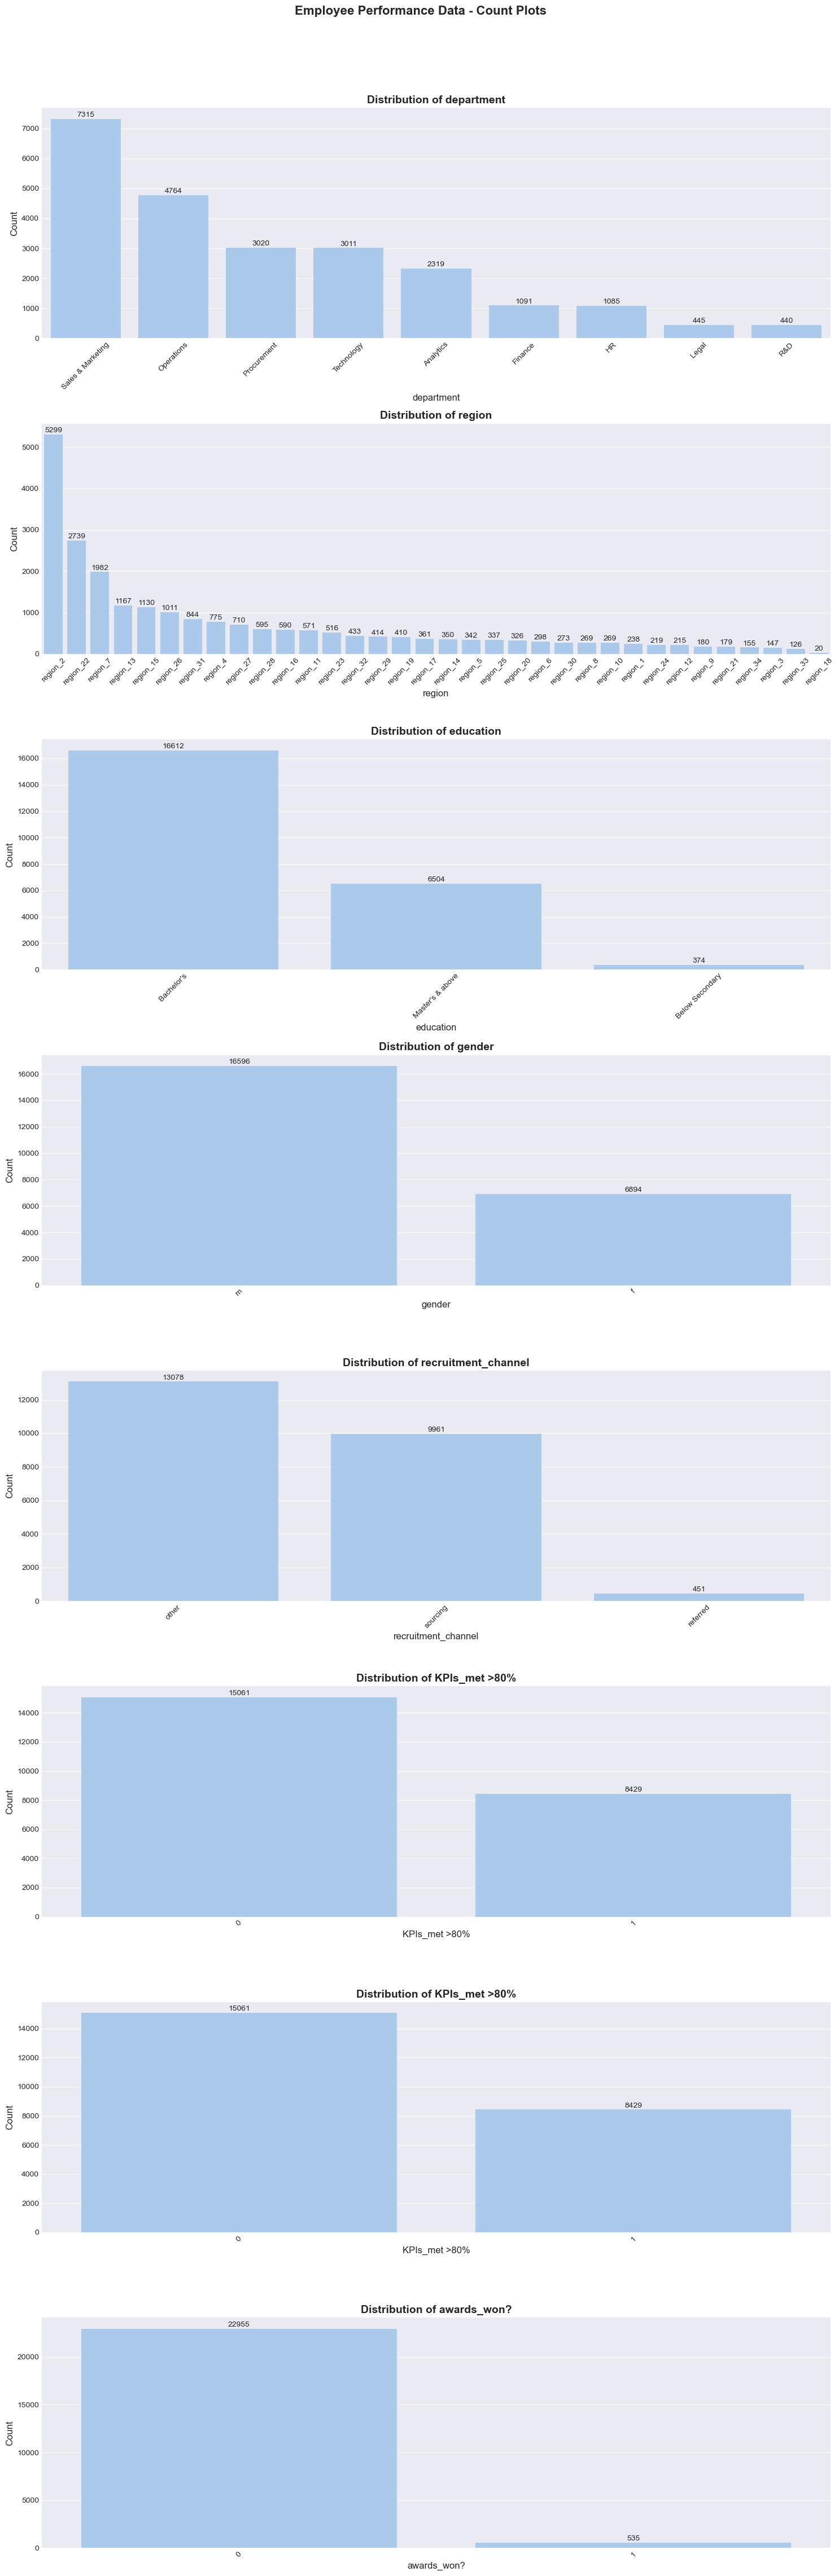

In [65]:
# --- 4. Generate Count Plots for Categorical Features ---
print("\n--- Generating Count Plots ---")

num_features_plot = len(categorical_features_for_plot)
if num_features_plot == 0:
    print("No categorical features found to plot count plots for.")
else:
    n_cols_plot = 1
    n_rows_plot = (num_features_plot + n_cols_plot - 1) // n_cols_plot

    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, 6 * n_rows_plot))
    axes = axes.flatten()

    for i, feature in enumerate(categorical_features_for_plot):
        ax = axes[i]
        sns.countplot(data=df, x=feature, ax=ax, order=df[feature].value_counts().index)

        ax.set_title(f'Distribution of {feature}', fontsize=14, fontweight='bold')
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.tick_params(axis='x', rotation=45)

        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Employee Performance Data - Count Plots', fontsize=16, fontweight='bold', y=0.98)
    plt.show()


In [67]:
# --- 5. Identify Unique Values and Their Counts ---
print("\n--- Unique Values and Their Counts for Categorical Features ---")
for feature in categorical_features_for_plot:
    print(f"\nFeature: '{feature}'")
    unique_counts = df[feature].value_counts()
    print(unique_counts)
    print("-" * 30)


--- Unique Values and Their Counts for Categorical Features ---

Feature: 'department'
department
Sales & Marketing    7315
Operations           4764
Procurement          3020
Technology           3011
Analytics            2319
Finance              1091
HR                   1085
Legal                 445
R&D                   440
Name: count, dtype: int64
------------------------------

Feature: 'region'
region
region_2     5299
region_22    2739
region_7     1982
region_13    1167
region_15    1130
region_26    1011
region_31     844
region_4      775
region_27     710
region_28     595
region_16     590
region_11     571
region_23     516
region_32     433
region_29     414
region_19     410
region_17     361
region_14     350
region_5      342
region_25     337
region_20     326
region_6      298
region_30     273
region_8      269
region_10     269
region_1      238
region_24     219
region_12     215
region_9      180
region_21     179
region_34     155
region_3      147
region_3

In [69]:
# --- 6. Infer Trends and Insights from Data Visualization ---
print("\n--- Key Trends and Insights from Data Visualization ---")
if 'KPIs_met >80%' in df.columns:
    print("\n**KPIs Met >80% Distribution:**")
    kpi_counts = df['KPIs_met >80%'].value_counts()
    print(f"Number of employees who met KPIs >80% (1): {kpi_counts.get(1, 0)}")
    print(f"Number of employees who did NOT meet KPIs >80% (0): {kpi_counts.get(0, 0)}")
    print("This distribution is crucial for understanding the balance of your target variable.")

if 'department' in df.columns:
    print("\n**Departmental Insights:**")
    print(f"The '{df['department'].mode()[0]}' department appears to have the highest number of employees in this dataset.")

if 'length_of_service' in df.columns:
    print("\n**Length of Service (Initial Observation):**")
    print(f"A significant portion of employees have been with the company for around {df['length_of_service'].mode()[0]} years.")

if 'gender' in df.columns:
    print("\n**Gender Distribution:**")
    print(f"The dataset shows a distribution of genders, with '{df['gender'].mode()[0]}' being more prevalent.")

if 'no_of_trainings' in df.columns:
    print("\n**Number of Trainings (Hypothesis):**")
    print(f"Most employees in the dataset have completed '{df['no_of_trainings'].mode()[0]}' training. "
          "This suggests training might be a common practice or a factor to investigate for its correlation with performance/KPIs.")

if 'awards_won?' in df.columns:
    print("\n**Awards Won Trends:**")
    award_counts = df['awards_won?'].value_counts()
    print(f"Number of employees who won awards (1): {award_counts.get(1, 0)}")
    print(f"Number of employees who did NOT win awards (0): {award_counts.get(0, 0)}")
    print("This can be a strong indicator of high performance.")

print("\n**Overall Observation (from Visualization):**")
print("These initial visualizations provide a foundational understanding of the employee data. "
      "Now, we will proceed with data scaling and building predictive models.")




--- Key Trends and Insights from Data Visualization ---

**KPIs Met >80% Distribution:**
Number of employees who met KPIs >80% (1): 8429
Number of employees who did NOT meet KPIs >80% (0): 15061
This distribution is crucial for understanding the balance of your target variable.

**Departmental Insights:**
The 'Sales & Marketing' department appears to have the highest number of employees in this dataset.

**Length of Service (Initial Observation):**
A significant portion of employees have been with the company for around 3 years.

**Gender Distribution:**
The dataset shows a distribution of genders, with 'm' being more prevalent.

**Number of Trainings (Hypothesis):**
Most employees in the dataset have completed '1' training. This suggests training might be a common practice or a factor to investigate for its correlation with performance/KPIs.

**Awards Won Trends:**
Number of employees who won awards (1): 535
Number of employees who did NOT win awards (0): 22955
This can be a strong i

In [71]:
# --- 7. Prepare Data for Machine Learning Model ---
print("\n--- Preparing Data for Machine Learning ---")

# Define features (X) and target (y)
# CHANGED: Target variable is now 'KPIs_met >80%'
X = df.drop('KPIs_met >80%', axis=1) # [cite: 1]
y = df['KPIs_met >80%'] # [cite: 1]

# Encode the target variable 'KPIs_met >80%' to numerical labels (0 or 1)
# LabelEncoder is typically for multi-class, but works fine for binary if you want string labels later.
# For binary 0/1, it's often not strictly necessary as they are already numerical.
# However, if the column is categorical (e.g. object type from CSV read), this ensures it's numerical.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# target_classes will now be the unique values in 'KPIs_met >80%', typically [0, 1]
target_classes = label_encoder.classes_.astype(str) # Convert to string for display if they were ints/bools
print(f"Original KPIs_met >80% Labels: {y.unique()}")
print(f"Encoded KPIs_met >80% Labels: {label_encoder.transform(y.unique())}")


# Identify categorical and numerical columns for preprocessing
# Exclude 'employee_id' as it's just an identifier and not a predictive feature
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.drop(['employee_id'], errors='ignore')
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print(f"\nNumerical columns: {list(numerical_cols)}")
print(f"Categorical columns: {list(categorical_cols)}")



--- Preparing Data for Machine Learning ---
Original KPIs_met >80% Labels: [1, 0]
Categories (2, int64): [0, 1]
Encoded KPIs_met >80% Labels: [1 0]

Numerical columns: ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score']
Categorical columns: ['department', 'region', 'education', 'gender', 'recruitment_channel']


In [75]:
# --- 8. Define Scalers and Models ---
scalers = {
    'No Scaling': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'MaxAbsScaler': MaxAbsScaler()
}

# IMPORTANT: RandomForestClassifier has been removed to focus selection on Boosting models
models = {
    'XGBoostClassifier': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBMClassifier': LGBMClassifier(random_state=42, min_data_in_leaf=1, min_data_in_bin=1),
    'CatBoostClassifier': CatBoostClassifier(random_state=42, verbose=0),
}

results = {}



--- Running Experiments: Scalers vs. ML Models ---

Applying Scaler: No Scaling

--- Training Model: XGBoostClassifier ---
XGBoostClassifier training complete with No Scaling.

Accuracy of XGBoostClassifier with No Scaling: 0.6835

Classification Report:
                   precision    recall  f1-score   support

Did Not Meet KPIs       0.72      0.83      0.77      3012
         Met KPIs       0.58      0.42      0.49      1686

         accuracy                           0.68      4698
        macro avg       0.65      0.63      0.63      4698
     weighted avg       0.67      0.68      0.67      4698



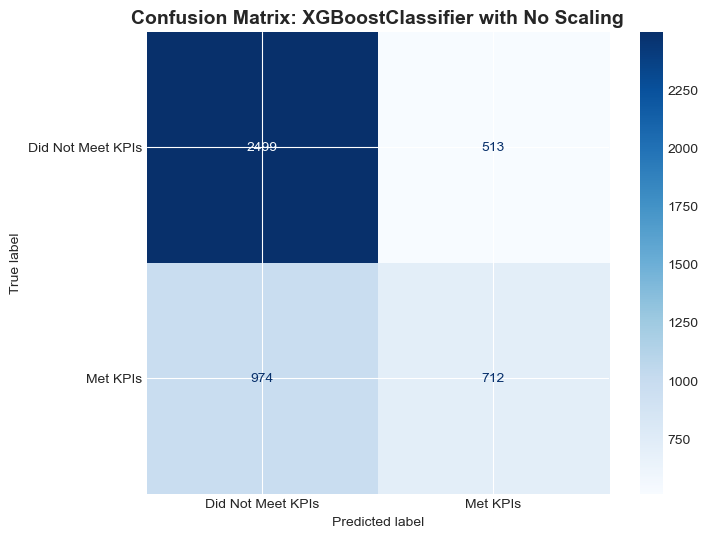


--- Training Model: LightGBMClassifier ---
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Number of positive: 6743, number of negative: 12049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 18792, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358823 -> initscore=-0.580477
[LightGBM] [Info] Start training from score -0.580477
LightGBMClassifier training complete with No Scaling.
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1

Accuracy of LightGBMClassifier with No Scaling: 0

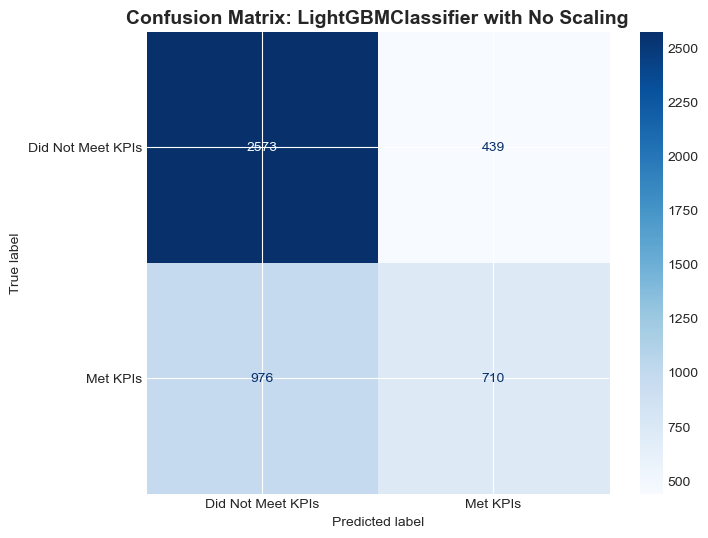


--- Training Model: CatBoostClassifier ---
CatBoostClassifier training complete with No Scaling.

Accuracy of CatBoostClassifier with No Scaling: 0.7005

Classification Report:
                   precision    recall  f1-score   support

Did Not Meet KPIs       0.73      0.85      0.79      3012
         Met KPIs       0.62      0.43      0.51      1686

         accuracy                           0.70      4698
        macro avg       0.67      0.64      0.65      4698
     weighted avg       0.69      0.70      0.68      4698



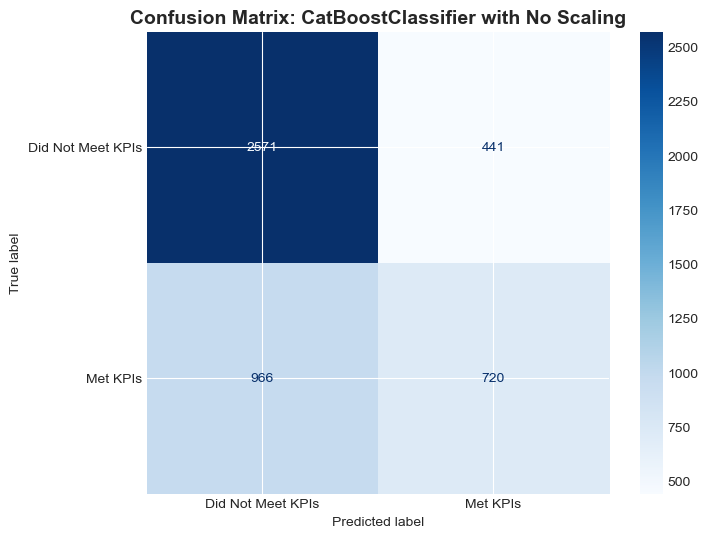


Applying Scaler: StandardScaler

--- Training Model: XGBoostClassifier ---
XGBoostClassifier training complete with StandardScaler.

Accuracy of XGBoostClassifier with StandardScaler: 0.6835

Classification Report:
                   precision    recall  f1-score   support

Did Not Meet KPIs       0.72      0.83      0.77      3012
         Met KPIs       0.58      0.42      0.49      1686

         accuracy                           0.68      4698
        macro avg       0.65      0.63      0.63      4698
     weighted avg       0.67      0.68      0.67      4698



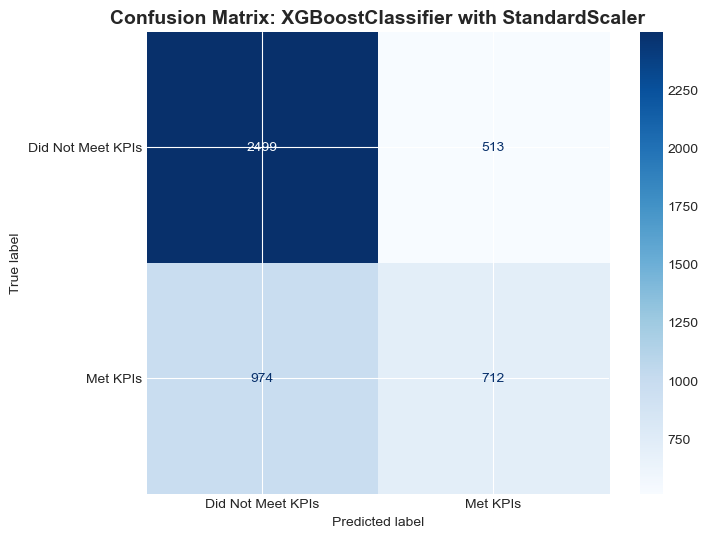


--- Training Model: LightGBMClassifier ---
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Number of positive: 6743, number of negative: 12049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 513
[LightGBM] [Info] Number of data points in the train set: 18792, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358823 -> initscore=-0.580477
[LightGBM] [Info] Start training from score -0.580477
LightGBMClassifier training complete with StandardScaler.
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: m

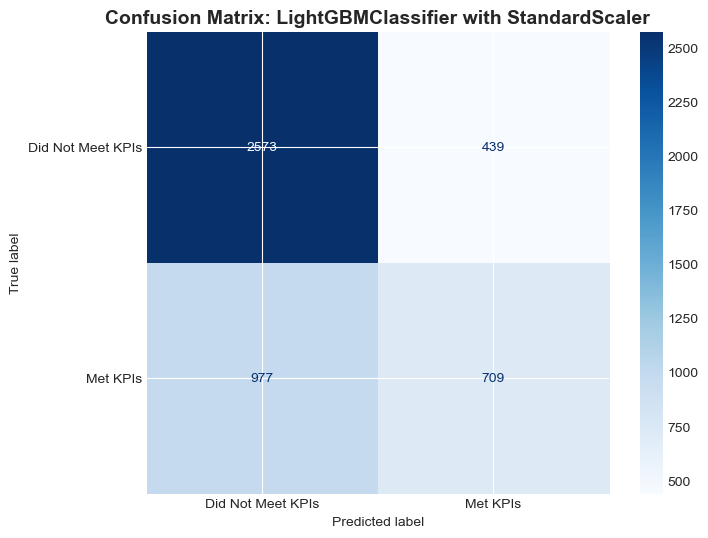


--- Training Model: CatBoostClassifier ---
CatBoostClassifier training complete with StandardScaler.

Accuracy of CatBoostClassifier with StandardScaler: 0.7005

Classification Report:
                   precision    recall  f1-score   support

Did Not Meet KPIs       0.73      0.85      0.79      3012
         Met KPIs       0.62      0.43      0.51      1686

         accuracy                           0.70      4698
        macro avg       0.67      0.64      0.65      4698
     weighted avg       0.69      0.70      0.68      4698



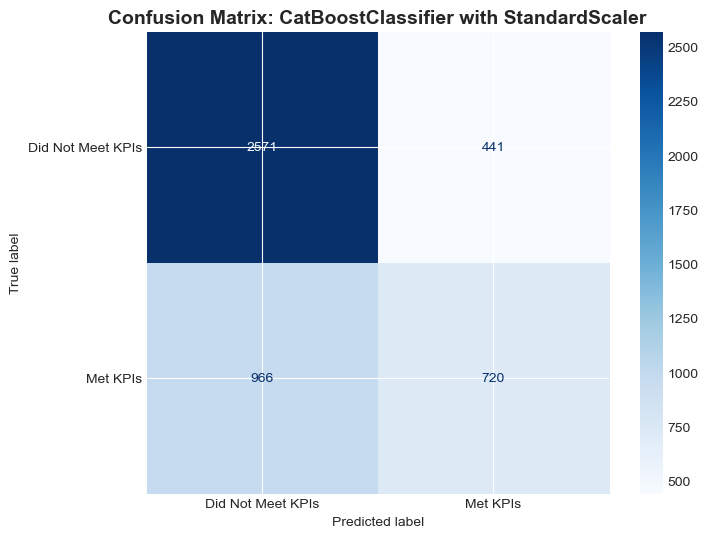


Applying Scaler: MinMaxScaler

--- Training Model: XGBoostClassifier ---
XGBoostClassifier training complete with MinMaxScaler.

Accuracy of XGBoostClassifier with MinMaxScaler: 0.6882

Classification Report:
                   precision    recall  f1-score   support

Did Not Meet KPIs       0.72      0.83      0.77      3012
         Met KPIs       0.59      0.43      0.50      1686

         accuracy                           0.69      4698
        macro avg       0.66      0.63      0.64      4698
     weighted avg       0.68      0.69      0.67      4698



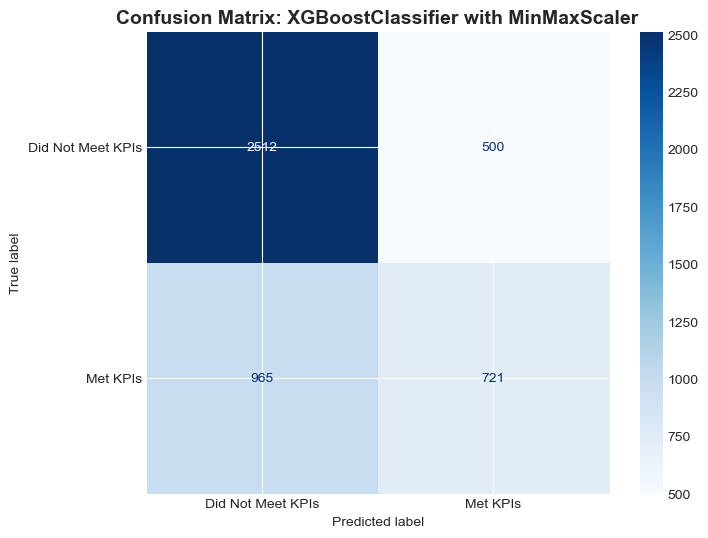


--- Training Model: LightGBMClassifier ---
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Number of positive: 6743, number of negative: 12049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 18792, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358823 -> initscore=-0.580477
[LightGBM] [Info] Start training from score -0.580477
LightGBMClassifier training complete with MinMaxScaler.
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min

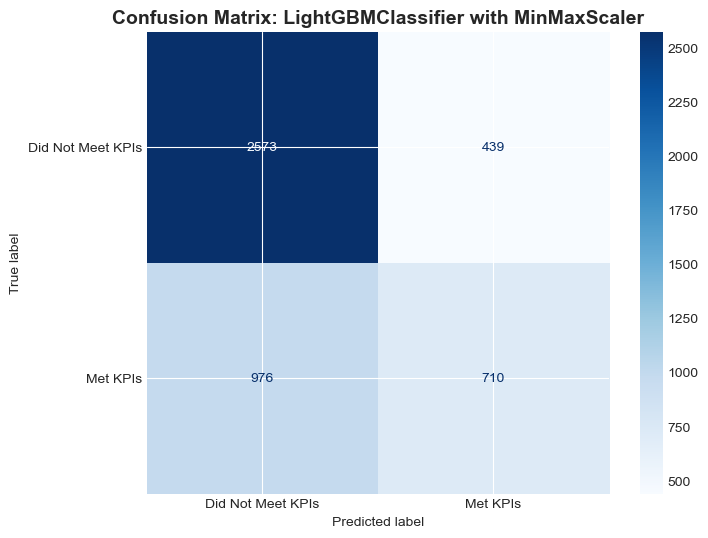


--- Training Model: CatBoostClassifier ---
CatBoostClassifier training complete with MinMaxScaler.

Accuracy of CatBoostClassifier with MinMaxScaler: 0.7005

Classification Report:
                   precision    recall  f1-score   support

Did Not Meet KPIs       0.73      0.85      0.79      3012
         Met KPIs       0.62      0.43      0.51      1686

         accuracy                           0.70      4698
        macro avg       0.67      0.64      0.65      4698
     weighted avg       0.69      0.70      0.68      4698



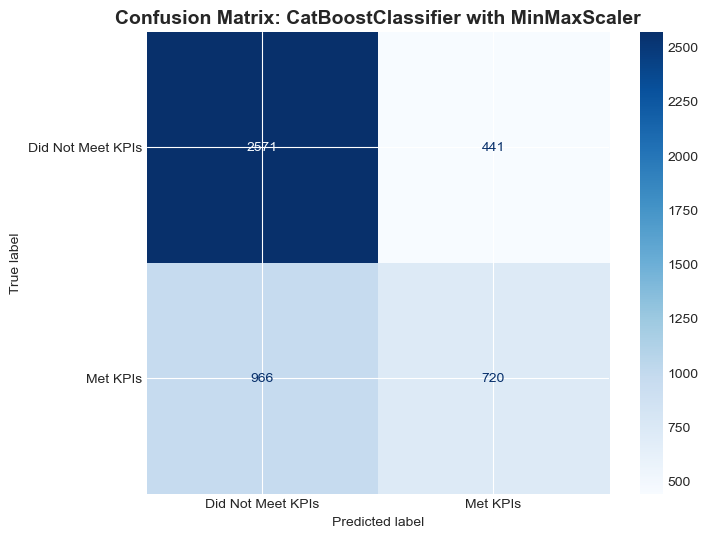


Applying Scaler: RobustScaler

--- Training Model: XGBoostClassifier ---
XGBoostClassifier training complete with RobustScaler.

Accuracy of XGBoostClassifier with RobustScaler: 0.6937

Classification Report:
                   precision    recall  f1-score   support

Did Not Meet KPIs       0.73      0.84      0.78      3012
         Met KPIs       0.60      0.43      0.50      1686

         accuracy                           0.69      4698
        macro avg       0.66      0.64      0.64      4698
     weighted avg       0.68      0.69      0.68      4698



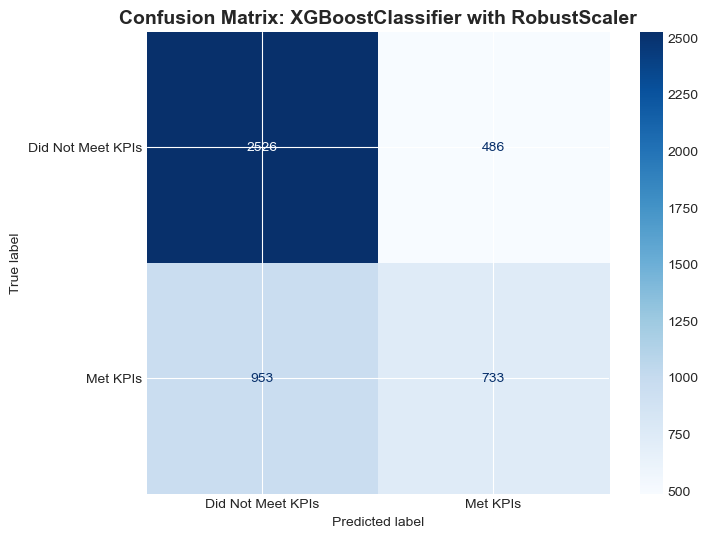


--- Training Model: LightGBMClassifier ---
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Number of positive: 6743, number of negative: 12049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 18792, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358823 -> initscore=-0.580477
[LightGBM] [Info] Start training from score -0.580477
LightGBMClassifier training complete with RobustScaler.
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min

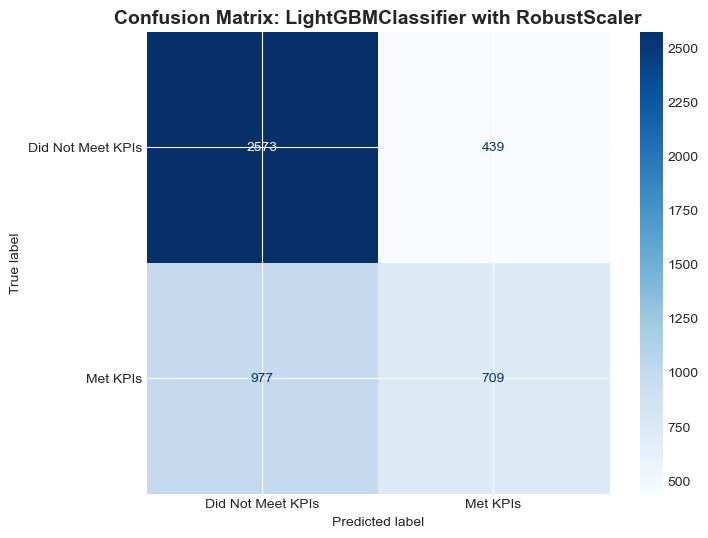


--- Training Model: CatBoostClassifier ---
CatBoostClassifier training complete with RobustScaler.

Accuracy of CatBoostClassifier with RobustScaler: 0.7005

Classification Report:
                   precision    recall  f1-score   support

Did Not Meet KPIs       0.73      0.85      0.79      3012
         Met KPIs       0.62      0.43      0.51      1686

         accuracy                           0.70      4698
        macro avg       0.67      0.64      0.65      4698
     weighted avg       0.69      0.70      0.68      4698



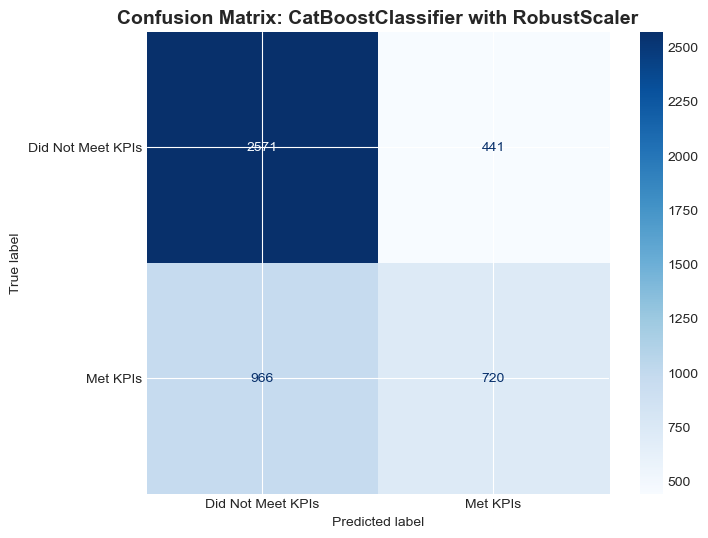


Applying Scaler: MaxAbsScaler

--- Training Model: XGBoostClassifier ---
XGBoostClassifier training complete with MaxAbsScaler.

Accuracy of XGBoostClassifier with MaxAbsScaler: 0.6835

Classification Report:
                   precision    recall  f1-score   support

Did Not Meet KPIs       0.72      0.83      0.77      3012
         Met KPIs       0.58      0.42      0.49      1686

         accuracy                           0.68      4698
        macro avg       0.65      0.63      0.63      4698
     weighted avg       0.67      0.68      0.67      4698



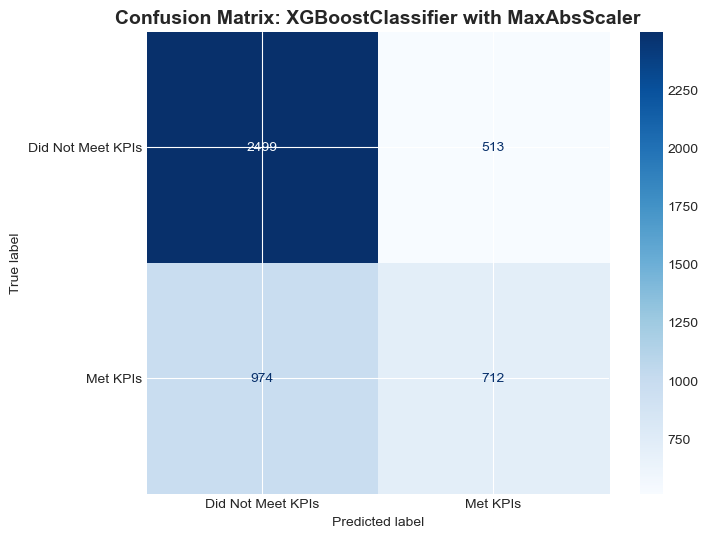


--- Training Model: LightGBMClassifier ---
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Number of positive: 6743, number of negative: 12049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 18792, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358823 -> initscore=-0.580477
[LightGBM] [Info] Start training from score -0.580477
LightGBMClassifier training complete with MaxAbsScaler.
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min

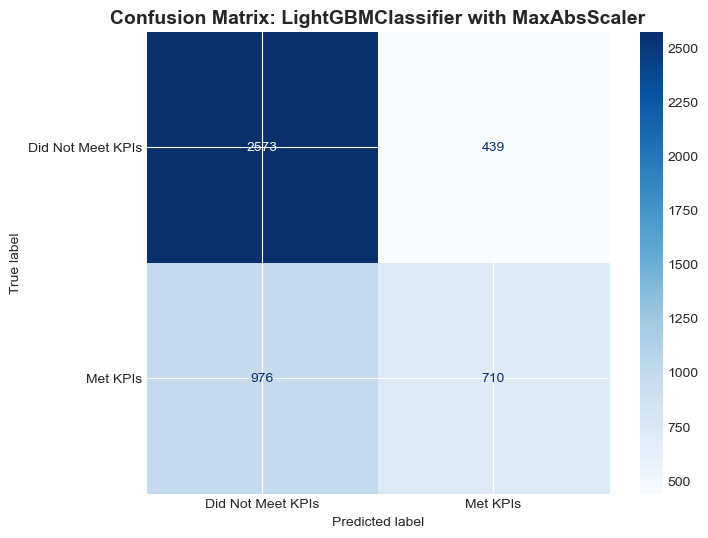


--- Training Model: CatBoostClassifier ---
CatBoostClassifier training complete with MaxAbsScaler.

Accuracy of CatBoostClassifier with MaxAbsScaler: 0.7005

Classification Report:
                   precision    recall  f1-score   support

Did Not Meet KPIs       0.73      0.85      0.79      3012
         Met KPIs       0.62      0.43      0.51      1686

         accuracy                           0.70      4698
        macro avg       0.67      0.64      0.65      4698
     weighted avg       0.69      0.70      0.68      4698



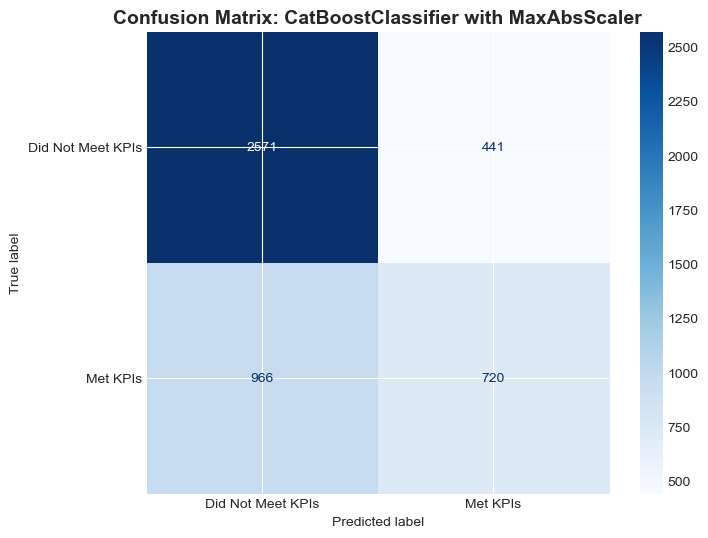

In [79]:
# --- 9. Iterate over Scalers and Models, Train, Evaluate, and Report ---
print("\n--- Running Experiments: Scalers vs. ML Models ---")

for scaler_name, scaler_instance in scalers.items():
    print(f"\n{'='*50}\nApplying Scaler: {scaler_name}\n{'='*50}") # Corrected: {scaler_name} instead of {scaler: {scaler_name}}

    # Create preprocessor for numerical and categorical features
    # Numerical features are scaled (if a scaler is provided)
    # Categorical features are one-hot encoded
    current_preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough' if scaler_instance is None else scaler_instance, numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough' # Keep other columns (like employee_id) but don't transform them
    )

    for model_name, model_instance in models.items():
        print(f"\n--- Training Model: {model_name} ---")

        # Split data, ensuring stratification for target balance
        X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        model_pipeline = Pipeline(steps=[('preprocessor', current_preprocessor),
                                         ('classifier', model_instance)])

        model_pipeline.fit(X_train, y_train_encoded)
        print(f"{model_name} training complete with {scaler_name}.")

        y_pred_encoded = model_pipeline.predict(X_test)

        accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
        print(f"\nAccuracy of {model_name} with {scaler_name}: {accuracy:.4f}")

        print("\nClassification Report:")
        # Ensure target_names align with the actual labels (0 and 1)
        print(classification_report(y_test_encoded, y_pred_encoded, target_names=['Did Not Meet KPIs', 'Met KPIs'], zero_division=0))

        cm = confusion_matrix(y_test_encoded, y_pred_encoded)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Meet KPIs', 'Met KPIs'])
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        ax.set_title(f'Confusion Matrix: {model_name} with {scaler_name}', fontsize=14, fontweight='bold')
        plt.show()

        results[f'{scaler_name}_{model_name}'] = {
            'accuracy': accuracy,
            'classification_report': classification_report(y_test_encoded, y_pred_encoded, target_names=['Did Not Meet KPIs', 'Met KPIs'], output_dict=True, zero_division=0),
            'confusion_matrix': cm
        }


In [81]:
# --- 10. Report Best Results ---
print("\n\n" + "="*60)
print("--- Comprehensive Performance Report: Scalers and ML Models (Focusing on Boosting) ---")
print("="*60)

best_accuracy = 0
best_combination = None

for combo, metrics in results.items():
    print(f"\n--- Results for {combo} ---")
    print(f"Accuracy: {metrics['accuracy']:.4f}")

    if metrics['accuracy'] > best_accuracy:
        best_accuracy = metrics['accuracy']
        best_combination = combo

print(f"\n{'*'*60}")
print(f"Best Performing Combination: {best_combination}")
print(f"Highest Accuracy Achieved: {best_accuracy:.4f}")
print(f"{'*'*60}\n")

print("\n--- Analysis of Best Combination ---")
if best_combination:
    best_scaler_name = '_'.join(best_combination.split('_')[:-1])
    best_model_name = best_combination.split('_')[-1]

    print(f"Model: {best_model_name}, Scaler: {best_scaler_name}")
    print(f"Accuracy: {results[best_combination]['accuracy']:.4f}")
    print("\nDetailed Classification Report for Best Model:")

    best_scaler_instance = scalers[best_scaler_name]
    best_model_instance = models[best_model_name]

    best_preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough' if best_scaler_instance is None else best_scaler_instance, numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    best_model_pipeline = Pipeline(steps=[('preprocessor', best_preprocessor),
                                          ('classifier', best_model_instance)])
    best_model_pipeline.fit(X_train, y_train_encoded)
    final_y_pred_encoded = best_model_pipeline.predict(X_test)

    print(classification_report(y_test_encoded, final_y_pred_encoded, target_names=['Did Not Meet KPIs', 'Met KPIs'], zero_division=0))

    final_cm = confusion_matrix(y_test_encoded, final_y_pred_encoded)
    final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=['Did Not Meet KPIs', 'Met KPIs'])
    fig, ax = plt.subplots(figsize=(8, 6))
    final_disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Final Best Model Confusion Matrix: {best_model_name} with {best_scaler_name}', fontsize=16, fontweight='bold')
    plt.show()

print("\n--- Conclusion ---")
print("This analysis demonstrates the impact of different data scaling techniques and machine learning models on employee performance prediction.")
print("The results indicate which combination yields the highest accuracy on this dataset.")
print("Further steps could involve hyperparameter tuning for the best model, cross-validation for more robust evaluation, and potentially collecting more data for better generalization.")
```

SyntaxError: invalid syntax (2247846842.py, line 60)